**Stable Diffusion XL

Stable Diffusion XL 是一个由 Base 模型和 Refiner 模型组成的二阶段级联扩散模型，旨在提高生成图像的质量和细节。其中，Base 模型和 Stable Diffusion 一致，具备文生图、图生图和图像 inpainting 等能力。在 Base 模型生成图像后，Refiner 模型会级联在 Base 模型之后，对 Base 模型生成的图像 Latent 特征进行进一步的精细化处理，从而提高生成图像的质量和细节。

Diffusion XL 2 阶段推理阶段，输入一个 prompt，通过 VAE 和 U-Net（Base）模型生成 Latent 特征，接着给这个 Latent 特征加一定的噪音，在此基础上，再使用 Refiner 模型进行去噪，以提升图像的整体质量与局部细节，本质上 Refiner 模型的本质就是在进行图生图的工作。

In [ ]:
!pip install diffusers

In [ ]:
#DiffusionPipeline
import torch
from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

#加载SDXL base model
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")

image = pipe(prompt=prompt,output_type="latent").images[0]

#加载SDXL refiner model
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)

#base model 输出,这里需output_type需要设置成为latent
images = pipe(prompt, output_type="latent").images
#refiner model 输出
images = refiner(prompt=prompt, image=images).images

#...images 保存处理

#controlnet模型初始化
def init_sdxl_control_net_pipeline(base_model,control_net_model):
    controlnet = ControlNetModel.from_pretrained(
            f"diffusers/controlnet-{control_net_model}-sdxl-1.0-small",
            variant="fp16",
            use_safetensors=True,
            torch_dtype=torch.float16,
        ).to("cuda")
    vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
            base_model,
            controlnet=controlnet,
            vae=vae,
            variant="fp16",
            use_safetensors=True,
            torch_dtype=torch.float16,
        ).to("cuda")
    return pipe

### Diffusers Components

- The DiffusionPipeline is a high-level end-to-end class designed to rapidly generate samples from pretrained diffusion models for inference.
    
- Popular pretrained model architectures and modules that can be used as building blocks for creating diffusion systems.
    
- Many different schedulers - algorithms that control how noise is added for training, and how to generate denoised images during inference.

In [ ]:
# uncomment to install the necessary libraries in Colab

!pip install --upgrade diffusers accelerate transformers

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)

pipeline

pipeline.to("cuda")

image = pipeline("An image of a squirrel in Picasso sytle").images[0]

image.save("Temp/squirrel.png")

image

In [ ]:
from diffusers import DiffusionPipeline

#pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)

pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", use_safetensors=True)

pipeline

pipeline.to("cuda")

image = pipeline("An image of a boy playing with wooden Guitar on an stage").images[0]

image.save("Temp/boy.png")

image

In [ ]:
import os

print(os.getcwd())

In [ ]:
# Change scheduler from PNDMScheudler to EulerDiscreteScheduler

from diffusers import EulerDiscreteScheduler

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)

pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)


In [ ]:
pipeline.to("cuda")

image = pipeline("An image of a boy playing with wooden Guitar on an stage", num_inference_steps=200).images[0]

image.save("Temp/boy.png")

image

In [ ]:
# Try to run faster 

from diffusers import DiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"

pipeline = DiffusionPipeline.from_pretrained(model_id, use_safetensors=True)

prompt = "portrait photo of a old warrior chief"

pipeline.to("cuda")

import torch

generator = torch.Generator("cuda").manual_seed(0)

image = pipeline(prompt, generator=generator).images[0]

image.save("Temp/warror.png")

image

In [ ]:
# Change to float16 and num of inference steps to 200

import torch

from diffusers import DiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"

pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)

pipeline = pipeline.to("cuda")

generator = torch.Generator("cuda").manual_seed(0)

prompt = "portrait photo of a old warrior chief"

image = pipeline(prompt, generator=generator, num_inference_steps=200).images[0]

image

In [ ]:
# Check the compatible schedulers

pipeline.scheduler.compatibles

In [ ]:
# Try to overflow the memory

import torch

from diffusers import DiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"

pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)

pipeline = pipeline.to("cuda")

prompt = "portrait photo of an old warrior chief"

def get_inputs(batch_size=1):
    generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20
    
    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

from diffusers.utils import make_image_grid

# Enable slicing to protect the memory
#pipeline.enable_attention_slicing()

images = pipeline(**get_inputs(batch_size=8)).images

from diffusers.utils import make_image_grid

make_image_grid(images, 2, 4)

In [ ]:
# Try to load latest autoencoder from Stability AI

from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")

pipeline.vae = vae

prompt += ", tribal panther make up, blue on red, side profile, looking away, serious eyes"
prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"

images = pipeline(**get_inputs(batch_size=8)).images

make_image_grid(images, rows=2, cols=4)

In [ ]:
prompts = [
    "portrait photo of the oldest warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a young warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
]

generator = [torch.Generator("cuda").manual_seed(1) for _ in range(len(prompts))]
images = pipeline(prompt=prompts, generator=generator, num_inference_steps=25).images
make_image_grid(images, 2, 2)

In [ ]:
# Generate a cat with goole/ddpm-cat-256

from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

image = ddpm(num_inference_steps=30).images[0]

image

In [ ]:
# Try to recreate the pipeline

from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")

model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

scheduler.set_timesteps(50)

scheduler.timesteps

import torch

sample_size = model.config.sample_size

noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample
    

from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)

image


In [ ]:
# AutoPipelineForText2Image

from diffusers import AutoPipelineForText2Image

import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

prompt = "peasant and dragon combat, wood cutting style, viking era, bevel with rune"

image = pipeline(prompt, num_inference_steps=30).images[0]

image

In [ ]:
# Try AutoPipelineForImage2Image

from diffusers import AutoPipelineForImage2Image
import torch
import requests
from PIL import Image
from io import BytesIO

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype = torch.float16,
    use_safetensors = True,
).to("cuda")

prompt = "a portrait of a dog wearing a pearl earring"

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/1665_Girl_with_a_Pearl_Earring.jpg/800px-1665_Girl_with_a_Pearl_Earring.jpg"
response = requests.get(url)

image = Image.open(BytesIO(response.content)).convert("RGB")
image.thumbnail((768, 768))

image = pipeline(prompt, image, num_inference_steps=200, strength=0.75, guidance_scale=10.5).images[0]

image.save("Temp/dog.png")

image


In [ ]:
# Try AutoPipelineForInpainting

from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

pipeline = AutoPipelineForInpainting.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = load_image(img_url).convert("RGB")
mask_image = load_image(mask_url).convert("RGB")

prompt = "A majestic tiger sitting on a bench"
image = pipeline(prompt, image=init_image, mask_image=mask_image, num_inference_steps=50, strength=0.80).images[0]

image.save("Temp/tiger.png")

image

In [ ]:
# Use from_pipe to reuse the pipeline class

from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image
import torch

pipeline_text2img = AutoPipelineForText2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True
)

print(type(pipeline_text2img))

In [ ]:
pipeline_img2img = AutoPipelineForImage2Image.from_pipe(pipeline_text2img)
print(type(pipeline_img2img))

In [ ]:
# Try to use LoRA of adapter

from diffusers import DiffusionPipeline
import torch

pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16).to("cuda")

# Load LoRA adapter
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

prompt = "toy_face of a hacker with a hoodie"

lora_scale = 0.9

image = pipe(
    prompt, num_inferences_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]

image.save("Temp/toy.png")

image

In [ ]:
# Change to another adapter of pixel

pipe.load_lora_weights('nerijs/pixel-art-xl', weight_name="pixel-art-xl.safetensors", adapter_name="pixel")

pipe.set_adapters("pixel")

prompt = "a hacker with a hoodie, pixel art"

image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]

image

In [ ]:
# Install PEFT

!pip install peft

In [ ]:
# Combine two adapters

pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])

# Notice how the prompt is constructed.

prompt = "toy_face of a hacker with a hoodie, pixel art"

image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": 1.0}, generator=torch.manual_seed(0)
).images[0]

image

In [ ]:
# Back to one adapter again

pipe.set_adapters("toy")

prompt = "toy_face of a hacker with a hoodie"

lora_scale=0.9

image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]

image

In [ ]:
# Back to one adapter again

pipe.disable_lora()

prompt = "toy_face of a hacker with a hoodie"

lora_scale=0.9

image = pipe(
    prompt, num_inference_steps=30, generator=torch.manual_seed(0)
).images[0]

image.save("Temp/hacker.png")

image

In [ ]:
# Print the active adapters

active_adapters = pipe.get_active_adapters()
active_adapters

list_adapters = pipe.get_list_adapters()
list_adapters

### Accelerate the inference of Disffusion Models

Diffusion models are slower than their GAN counterparts because of the iterative and sequential reverse diffusion process. 

There are several techniques that can address this limitation such as progressive timestep distillation (LCM LoRA), model compression (SSD-1B), and reusing adjacent features of the denoiser (DeepCache).


In [ ]:
# Default SDXL without accelerating

from diffusers import StableDiffusionXLPipeline

# Load the pipeline in full-precision and place its model components on CUDA
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0"
).to("cuda")

# Run the attention ops without SDPA
pipe.unet.set_default_attn_processor()
pipe.vae.set_default_attn_processor()

prompt = "Astronaut in a jungle, code color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

image.save("Temp/astronaut.png")
image

In [ ]:
# Reduce precision to bfloat16

from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.bfloat16
).to("cuda")

# Run the attention ops without SDPA.
pipe.unet.set_default_attn_processor()
pipe.vae.set_default_attn_processor()

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

image

In [ ]:
# use SDPA

from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.bfloat16
).to("cuda")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

## torch.compile

torch.compile offers different backends and modes. For maximum inference speed, use “max-autotune” for the inductor backend. “max-autotune” uses CUDA graphs and optimizes the compilation graph specifically for latency. CUDA graphs greatly reduces the overhead of launching GPU operations by using a mechanism to launch multiple GPU operations through a single CPU operation.

In [ ]:
# Use torch.compile. 

from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.bfloat16
).to("cuda")

torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.coordinate_descent_check_all_directions = True

pipe.unet.to(memory_format=torch.channels_last)
pipe.vae.to(memory_format=torch.channels_last)

# Compile the UNet and VAE
pipe.unet = torch.compile(pipe.unet, mode="max-autotune", fullgraph=True)
pipe.vae.decode = torch.compile(pipe.vae.decode, mode="max-autotune", fullgraph=True)

prompt = "Astronaut in a jungle, code color palette, muted colors, detailed, 8k"

image = pipe(prompt, num_inference_steps=30).images[0]

image

In [ ]:
# Install PyTorch nightly to benefit from the latest and fastest kernels:

#pip3 install --pre torch --index-url https://download.pytorch.org/whl/nightly/cu121

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

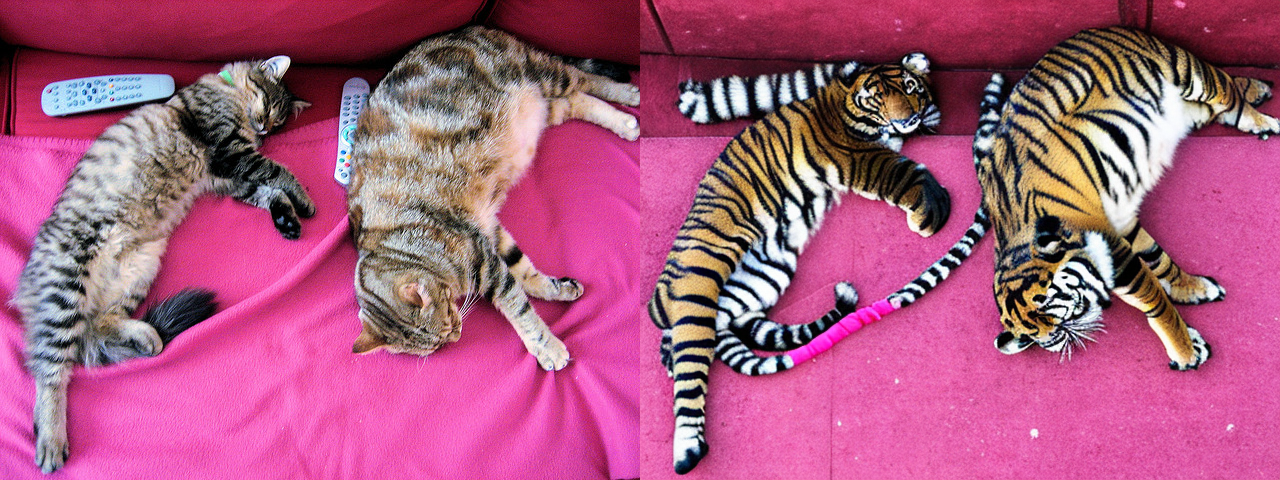

In [2]:
# Try with Depth2Img

import torch
from diffusers import StableDiffusionDepth2ImgPipeline
from diffusers.utils import load_image, make_image_grid

pipeline = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype = torch.float16,
    use_safetensors = True,
).to("cuda")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
init_image = load_image(url)

prompt = "tow tigers"
negative_prompt = "bad, deformed, ugly, bad anatomy"

image = pipeline(prompt=prompt, image=init_image, negative_prompt=negative_prompt, strength=0.7).images[0]

make_image_grid([init_image, image], rows=1, cols=2)


